# Important Definitions

### Players

    Player 1
    Player 2

### Colors

    red = 0
    green = 1 
    yellow = 2 
    blue = 3
    purple = 4 
    black = 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random

class Board:  
    # Initialized a random board using np.random.randint and then calls fix_board to make sure there 
    # are no cells with the same color are already touching to match the filler game.
    def __init__(self, size = (7,8)):
        self.size = size
        self.data = np.random.randint(0, high=5, size=self.size)
        self.fix_board()
        
        self.player_1_color = self.data[self.size[0]-1,0]
        self.player_2_color = self.data[0,self.size[1]-1]
        
        self.player_1_cells_captured = [(self.size[0]-1,0)]
        self.player_2_cells_captured = [(0,self.size[1]-1)]
        
        self.player_1_score = 1
        self.player_2_score = 1
        
        # For displaying the board (Defining: red = 0, green = 1, yellow = 2, blue = 3, purple = 4, black = 5)
        self.cmap = colors.ListedColormap(['red', 'green', 'yellow', 'blue', 'purple', 'black'])
        self.bounds = [0,1,2,3,4,5,6]
        self.norm = colors.BoundaryNorm(self.bounds, self.cmap.N)
      
    
    # Displays the board
    def display_board(self):
        fig, ax = plt.subplots()
        ax.imshow(self.data, cmap=self.cmap, norm=self.norm)
     
    
    # Retuns the current game score. Necessary for evaluating when the game has ended (when the two scores add
    # up to the total number of celss for the given board size).
    def get_score(self):
        return (self.player_1_score, self.player_2_score)
    
    
    # Returns the possible legal moves for the current board state.
    # Necessary for MCTC algorithm.
    def legal_moves(self):
        return np.setdiff1d([0,1,2,3,4,5],[self.player_1_color, self.player_2_color])
    
    
    # For finding which neighbors of a cell are within the bounds of the grid
    # Takes in a list of tuples giving the coordinates of the neighbors
    def valid_neighbors(self, neighbors):
        valid_neighbors = []
        for neighbor in neighbors:
            if neighbor[0] >= 0 and neighbor[0] < self.size[0] and neighbor[1] >= 0 and neighbor[1] < self.size[1]:
                valid_neighbors.append(neighbor)
        return valid_neighbors
    
    
    # Takes the random generated board and fixes it so that no no cells with the same color are 
    # already touching to match the filler game. 
    def fix_board(self):
        # Fixing blobs of colors
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                neighbors = self.valid_neighbors([(i+1,j), (i-1,j), (i,j+1), (i,j-1)])
                neighbor_colors = []
                for neighbor in neighbors:
                    neighbor_colors.append(self.data[neighbor[0], neighbor[1]])
                if len(np.intersect1d([self.data[i,j]], neighbor_colors)) > 0:
                    self.data[i,j] = random.choice(np.setdiff1d([0,1,2,3,4,5],neighbor_colors))
        
        # Fixing if starting colors of players are the same
        if self.data[self.size[0]-1,0] == self.data[0,self.size[1]-1]:
            self.data[0,self.size[1]-1] = random.choice(np.setdiff1d([0,1,2,3,4,5],[self.data[0,self.size[1]-1], 
                                            self.data[0,self.size[1]-2], self.data[1,self.size[1]-1]]))
        
        # Fixing to make sure a player can never start the game off with two neighbors of the same color
        if self.data[self.size[0]-2,0] == self.data[self.size[0]-1, 1]:
            cells_to_avoid = [(self.size[0]-3,0), (self.size[0]-1,0), (self.size[0]-2,1), (self.size[0]-1,1)]
            colors_to_avoid = []
            for cell in cells_to_avoid:
                colors_to_avoid.append(self.data[cell[0], cell[1]])
            self.data[self.size[0]-2,0] = random.choice(np.setdiff1d([0,1,2,3,4,5],colors_to_avoid))
        if self.data[0, self.size[1]-2] == self.data[1, self.size[1]-1]:
            cells_to_avoid = [(0,self.size[1]-3), (0,self.size[1]-1), (1,self.size[1]-2), (1,self.size[1]-1)]
            colors_to_avoid = []
            for cell in cells_to_avoid:
                colors_to_avoid.append(self.data[cell[0], cell[1]])
            self.data[0,self.size[1]-2] = random.choice(np.setdiff1d([0,1,2,3,4,5],colors_to_avoid))
            
             
    # Updates the board based on the given player and the color value.
    def update_board(self, player_number, color_value):
        if player_number == 1:
            if color_value == self.player_2_color:
                raise Exception("Trying to choose the color of the other player")
            new_captures = []
            
            # Finding all neighboring cells with the given chosen color
            for cell in self.player_1_cells_captured:
                neighbors = self.valid_neighbors([(cell[0]+1,cell[1]), (cell[0]-1,cell[1]), 
                                                  (cell[0],cell[1]+1), (cell[0],cell[1]-1)])
                for neighbor in neighbors:
                    if self.data[neighbor[0],neighbor[1]] == color_value:
                        self.data[neighbor[0],neighbor[1]] = color_value
                        new_captures.append(neighbor)
            
            # Updating all current captured territory to have the new chosen color
            for cell in self.player_1_cells_captured:
                self.data[cell] = color_value
            
            # Updating metadeta
            self.player_1_cells_captured = list(set().union(self.player_1_cells_captured,new_captures)) 
            self.player_1_score = len(self.player_1_cells_captured)
            self.player_1_color = color_value
        
        elif player_number == 2:
            if color_value == self.player_1_color:
                raise Exception("Trying to choose the color of the other player")
            new_captures = []
            
            # Finding all neighboring cells with the given chosen color
            for cell in self.player_2_cells_captured:
                neighbors = self.valid_neighbors([(cell[0]+1,cell[1]), (cell[0]-1,cell[1]), 
                                                  (cell[0],cell[1]+1), (cell[0],cell[1]-1)])
                for neighbor in neighbors:
                    if self.data[neighbor[0],neighbor[1]] == color_value:
                        self.data[neighbor[0],neighbor[1]] = color_value
                        new_captures.append(neighbor)
            
            # Updating all current captured territory to have the new chosen color
            for cell in self.player_2_cells_captured:
                self.data[cell] = color_value
            
            # Updating metadeta
            self.player_2_cells_captured = list(set().union(self.player_2_cells_captured,new_captures))
            self.player_2_score = len(self.player_2_cells_captured)
            self.player_2_color = color_value
        
        else:
               raise Exception("Invalid player number")
                
    
    # Returns the greedy move based on maximizing the number of cells gained in the next turn
    # for a given player. Note, it returns the maximum legal move (it can't choose the other 
    # players current color).
    def greedy_move(self, player_number):
        territory_neighbors = set()
        num_colored_neighbors = np.zeros(6)        
        
        if player_number == 1:
            # Finding all neighbors and adding them to the running total of num_colored_neighbors
            for cell in self.player_1_cells_captured:
                neighbors = set(self.valid_neighbors([(cell[0]+1,cell[1]), (cell[0]-1,cell[1]), 
                                                  (cell[0],cell[1]+1), (cell[0],cell[1]-1)])) 
                territory_neighbors = territory_neighbors.union(neighbors)
            territory_neighbors = list(territory_neighbors - set(self.player_1_cells_captured))
            for neighbor in territory_neighbors:
                num_colored_neighbors[self.data[neighbor]] += 1            
            
            # Return the top color but checking to make sure we're not chossing the other player's color  
            top_colors = np.argsort(num_colored_neighbors)
            if top_colors[-1] == self.player_2_color:
                return top_colors[-2]
            else:
                return top_colors[-1]      
        
        elif player_number == 2:         
            # Finding all neighbors and adding them to the running total of num_colored_neighbors
            for cell in self.player_2_cells_captured:
                neighbors = set(self.valid_neighbors([(cell[0]+1,cell[1]), (cell[0]-1,cell[1]), 
                                                  (cell[0],cell[1]+1), (cell[0],cell[1]-1)])) 
                territory_neighbors = territory_neighbors.union(neighbors) 
            territory_neighbors = list(territory_neighbors - set(self.player_2_cells_captured))
            for neighbor in territory_neighbors:
                num_colored_neighbors[self.data[neighbor]] += 1       
            
            # Return the top color but checking to make sure we're not chossing the other player's color  
            top_colors = np.argsort(num_colored_neighbors)
            if top_colors[-1] == self.player_1_color:
                return top_colors[-2]
            else:
                return top_colors[-1]        
        
        else:
               raise Exception("Invalid player number")

    red = 0
    green = 1 
    yellow = 2 
    blue = 3
    purple = 4 
    black = 5

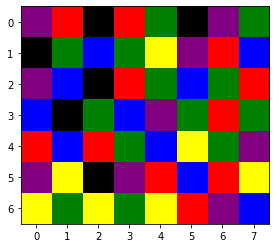

In [2]:
test = Board()
test.display_board()

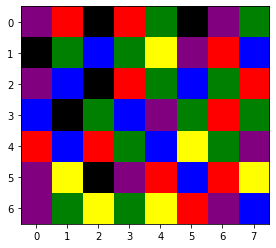

In [3]:
test.update_board(1,test.greedy_move(1))
test.display_board()

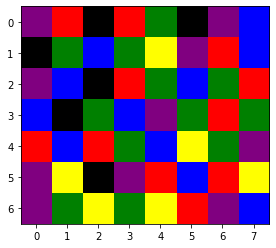

In [4]:
test.update_board(2,test.greedy_move(2))
test.display_board()

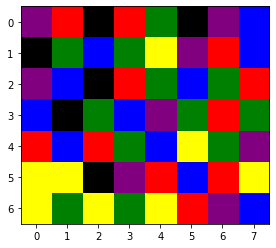

In [5]:
test.update_board(1,test.greedy_move(1))
test.display_board()

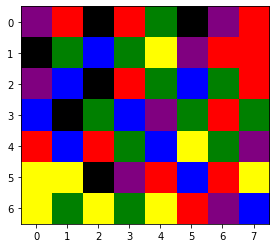

In [6]:
test.update_board(2,test.greedy_move(2))
test.display_board()

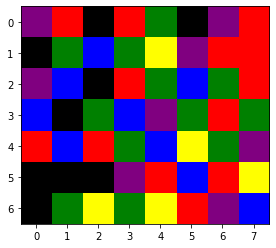

In [7]:
test.update_board(1,test.greedy_move(1))
test.display_board()

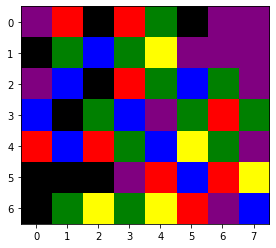

In [8]:
test.update_board(2,test.greedy_move(2))
test.display_board()

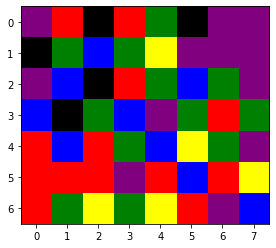

In [9]:
test.update_board(1,test.greedy_move(1))
test.display_board()

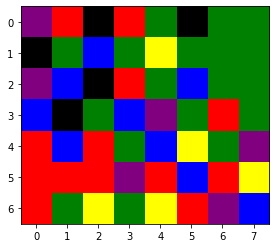

In [10]:
test.update_board(2,test.greedy_move(2))
test.display_board()

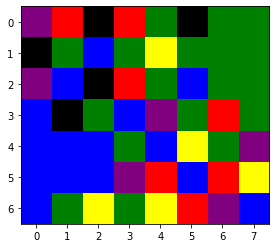

In [11]:
test.update_board(1,test.greedy_move(1))
test.display_board()

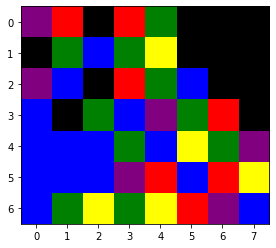

In [12]:
test.update_board(2,test.greedy_move(2))
test.display_board()

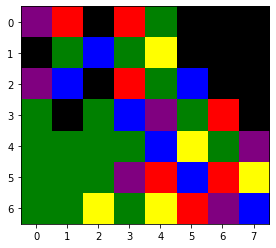

In [13]:
test.update_board(1,test.greedy_move(1))
test.display_board()

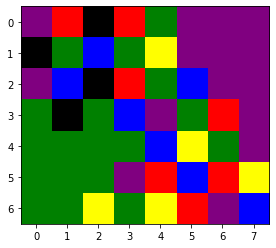

In [14]:
test.update_board(2,test.greedy_move(2))
test.display_board()

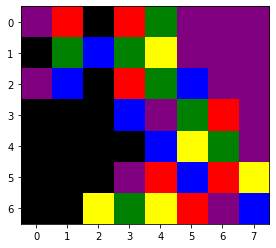

In [15]:
test.update_board(1,test.greedy_move(1))
test.display_board()

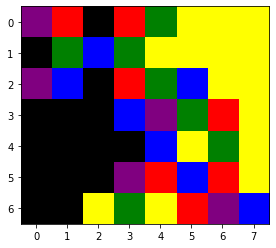

In [16]:
test.update_board(2,test.greedy_move(2))
test.display_board()

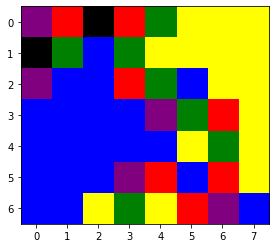

In [17]:
test.update_board(1,test.greedy_move(1))
test.display_board()

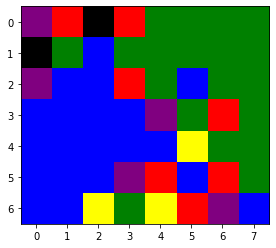

In [18]:
test.update_board(2,test.greedy_move(2))
test.display_board()

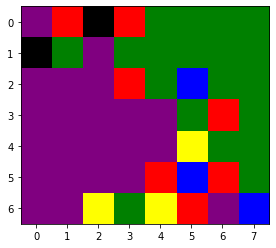

In [19]:
test.update_board(1,test.greedy_move(1))
test.display_board()

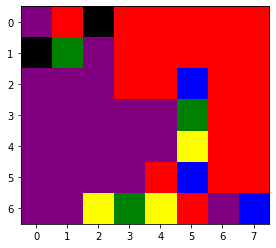

In [20]:
test.update_board(2,test.greedy_move(2))
test.display_board()

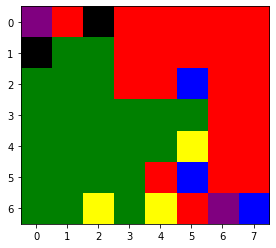

In [21]:
test.update_board(1,test.greedy_move(1))
test.display_board()

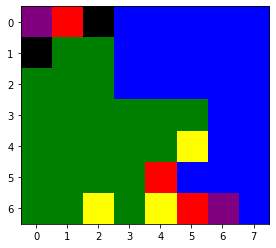

In [22]:
test.update_board(2,test.greedy_move(2))
test.display_board()

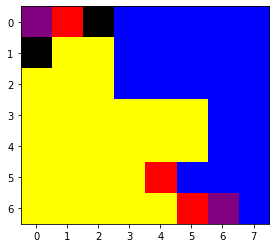

In [23]:
test.update_board(1,test.greedy_move(1))
test.display_board()

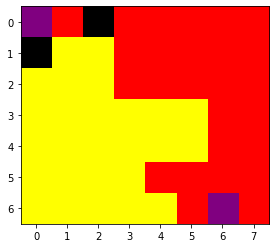

In [24]:
test.update_board(2,test.greedy_move(2))
test.display_board()

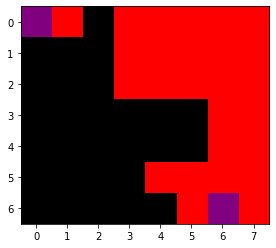

In [25]:
test.update_board(1,test.greedy_move(1))
test.display_board()

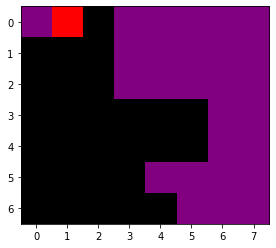

In [26]:
test.update_board(2,test.greedy_move(2))
test.display_board()

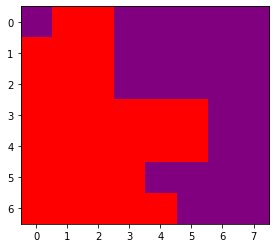

In [27]:
test.update_board(1,test.greedy_move(1))
test.display_board()

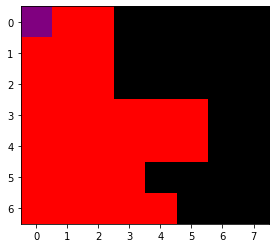

In [28]:
test.update_board(2,test.greedy_move(2))
test.display_board()

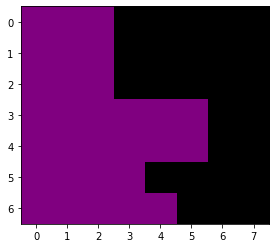

In [29]:
test.update_board(1,test.greedy_move(1))
test.display_board()

In [30]:
test.get_score()

(30, 26)